In [1]:
# loading libraries
%load_ext autoreload
%autoreload 2
import sys, os, re
from collections import Counter
import pandas as pd
import numpy as np
from IPython.display import display
sys.path.append(os.path.abspath('../Code'))
from helpers import cumulative_fraction, grams, transpose_note_list
from plot_helpers import *
#from expand_labels import expand_labels, SliceMaker, fifths2name
from ms3.utils import load_tsv, fifths2name, fifths2name, fifths2pc
from ms3.expand_dcml import SM
from ms3 import Parse
#from harmony import regex
#REGEX = re.compile(regex, re.VERBOSE)
from plotly.subplots import make_subplots
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [2]:
# Helper functions
                                     
def plot_cum(S=None, cum=None, x_log=False, markersize=2, left_range=(-0.1, 4.40), right_range=(-0.023,1.099), **kwargs):
    """Pass either a Series or cumulative_fraction(S).reset_index()"""
    if cum is None:
        cum = cumulative_fraction(S).reset_index()
        cum.index = cum.index + 1
    fig = make_subplots(specs=[[{"secondary_y": True,}]])
    ix = cum.index
    fig.add_trace(
        go.Scatter(x=ix, y=cum.x, text=cum['index'], name="Absolute count", mode='markers', marker=dict(size=markersize)),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=ix, y=cum.y, text=cum['index'], name="Cumulative fraction", mode='markers', marker=dict(size=markersize)),
        secondary_y=True,
    )
    fig.update_xaxes(title_text="Rank of chord label", zeroline=False, gridcolor='lightgrey')
    if x_log:
        ranks = np.log(len(ix))/np.log(10)
        fig.update_xaxes(type='log', range=(-0.01*ranks, 1.01*ranks))
    else:
        ranks = len(ix)
        fig.update_xaxes(range=(-0.02*ranks, 1.02*ranks))
    fig.update_yaxes(title_text="Absolute label count", secondary_y=False, type='log', gridcolor='grey', zeroline=True, dtick=1, range=left_range)
    fig.update_yaxes(title_text="Cumulative fraction", secondary_y=True, gridcolor='lightgrey', zeroline=False, dtick=0.1, range=right_range)
    fig.update_layout(**kwargs)
    return fig

def transition_matrix(l=None, gs=None, n=2, k=None, smooth=0, normalize=False, IC=False, filt=None, dist_only=False,sort=False, decimals=2):
    """Returns a transition table from a list of symbols.

    Column index is the last item of grams, row index the n-1 preceding items.

    Parameters
    ----------

    l: list, optional
        List of elements between which the transitions are calculated.
        List can be nested.
    gs: list, optional
        List of tuples being n-grams
    n: int, optional
        get n-grams
    k: int, optional
        Number of rows and columns that you want to keep
    smooth: number, optional
        initial count value of all transitions
    normalize: bool, optional
        set True to divide every row by the sum of the row.
    IC: bool, optional
        Set True to calculate information content.
    filt: list, optional
        elements you want to exclude from the table. All ngrams containing at least one
        of the elements will be filtered out.
    dist_only: bool, optional
        if True, n-grams consisting only of identical elements are filtered out
    """
    if gs is None:
        assert (n>0), f"Cannot print {n}-grams"
        gs = grams(l, n=n)
    elif l is not None:
        assert True, "Specify either l or gs, not both."

    if filt:
        gs = list(filter(lambda n: not any(g in filt for g in n),gs))
    if dist_only:
        gs = list(filter(lambda tup: any(e != tup[0] for e in tup),gs))
    ngrams = pd.Series(gs).value_counts()
    ngrams.index = [(' '.join(t[:-1]),t[-1]) for t in ngrams.index.tolist()]
    context = pd.Index(set([ix[0] for ix in ngrams.index]))
    consequent = pd.Index(set([ix[1] for ix in ngrams.index]))
    df = pd.DataFrame(smooth, index=context, columns=consequent)


    for i, (cont, cons) in enumerate(ngrams.index):
        try:
            df.loc[cont, cons] += ngrams[i]
        except:
            continue



    if k is not None:
        sort=True

    if sort:
        h_sort = list(df.max().sort_values(ascending= False).index.values)
        #v_sort = list(df.max(axis=1).sort_values(ascending= False).index.values)
        #df = df[h_sort].loc[v_sort]
        

    SU = df.sum(axis=1)
    if normalize or IC:
        df = df.div(SU,axis=0)

    if IC:
        ic = np.log2(1/df)
        ic['entropy'] = (ic * df).sum(axis=1)
        ############## Identical calucations:
        #ic['entropy2'] = scipy.stats.entropy(df.transpose(),base=2)
        #ic['entropy3'] = -(df * np.log2(df)).sum(axis=1)
        df = ic
        if normalize:
            df['entropy'] = df['entropy'] / np.log2(len(df.columns)-1)
    else:
        df['total'] = SU

    if sort:
        sorted_rows = [df.loc[[i]].sort_values(by=df.loc[[i]].index[0], axis=1, ascending=IC).iloc[:, :k].round(decimals) for i in h_sort[:k]]
        for s in sorted_rows:
            display(s)
        return None
    elif k is not None:
        df = df.iloc[:k, :k]

    if decimals is not None:
        df = df.round(decimals)

    return df

# Use ms3 to parse the expanded harmony TSVs

In [3]:
p = Parse('.',  file_re='tsv$', exclude_re='AN.tsv$', index='fname', folder_re='harmonies')
p

93 files.
KEY                                 -> EXTENSIONS
-------------------------------------------------
Couperin-gouts_reunis/harmonies     -> {'.tsv': 58}
Couperin-concerts_royaux/harmonies  -> {'.tsv': 26}
Couperin-L'art_de_toucher/harmonies -> {'.tsv': 9}

In [4]:
{key: [t[0] for t in ix] for key, ix in p.index(per_key=True).items()}

{'Couperin-gouts_reunis/harmonies': ['c05n01_prelude',
  'c05n02_allemande',
  'c05n03_sarabande',
  'c05n04_gavote',
  'c05n05_musete',
  'c06n01_grave',
  'c06n02_allemande',
  'c06n03_sarabande',
  'c06n04_air_diable',
  'c06n05_siciliene',
  'c07n01_grave',
  'c07n02_allemande',
  'c07n03_sarabande',
  'c07n04_fuguete',
  'c07n05_gavote',
  'c07n06_siciliene',
  'c08n01_ouverture',
  'c08n02_ritournele',
  'c08n03_air',
  'c08n04_air_tendre',
  'c08n05_air_leger',
  'c08n06_Loure',
  'c08n07_air',
  'c08n08_sarabande',
  'c08n09_air_leger',
  'c08n10_air_lentement',
  'c08n11_air_baccantes',
  'c09n01_charme',
  'c09n02_lenjouement',
  'c09n03_graces',
  'c09n04_Lejene',
  'c09n05_vivacite',
  'c09n06_Sarabande',
  'c09n07_douceur',
  'c09n08_caetera',
  'c10n01_gravement',
  'c10n02_air',
  'c10n03_plainte',
  'c10n04_tromba',
  'c11n01_majestueusement',
  'c11n02_allemande',
  'c11n03_seconde_allemande',
  'c11n04_courante',
  'c11n05_seconde_courante',
  'c11n06_sarabande',
  'c

In [5]:
p = Parse('.', key='coup', exclude_re='AN.tsv$', file_re='tsv$', index='fname', folder_re='harmonies')
p.parse_tsv()
p

93 files.
KEY  -> EXTENSIONS
------------------
coup -> {'.tsv': 93}

All 93 tabular files have been parsed, 93 of them as Annotations object(s).
KEY  -> ANNOTATION LAYERS
-------------------------
coup -> staff  voice  label_type
     -> 1      1      3             9217
     ->        2      3               17
     -> 2      1      3                3
     -> 1      1      0               14

In [6]:
df = p.get_labels()
df['key_regions'] = df.groupby(level=0).localkey.apply(lambda col: col != col.shift()).cumsum()
df.head(20)

mc  mn mc_onset mn_onset timesig  staff  voice    label  \
fname                                                                      
00_allemande 0    1   0        0     5/16     4/4      1      1     .d.V   
             1    1   0     3/16      1/2     4/4      1      1       i6   
             2    1   0     7/16      3/4     4/4      1      1        i   
             3    2   1        0        0     4/4      1      1       V6   
             4    2   1      1/4      1/4     4/4      1      1        V   
             5    2   1      1/2      1/2     4/4      1      1     IV65   
             6    2   1      3/4      3/4     4/4      1      1       V7   
             7    3   2        0        0     4/4      1      1       i6   
             8    3   2      1/4      1/4     4/4      1      1      i\\   
             9    3   2      3/8      3/8     4/4      1      1      VI6   
             10   3   2      1/2      1/2     4/4      1      1      iio   
             11   3   2      5/8      5/8     4/4      1      1      VI6   
             12   3   2      3/4      3/4     4/4      1      1   V7/III   
             13   4   3        0        0     4/4      1      1    III\\   
             14   4   3      1/4      1/4     4/4      1      1      V64   
             15   4   3      1/2      1/2     4/4      1      1        i   
             16   4   3      3/4      3/4     4/4      1      1  v.iio64   
             17   4   3      7/8      7/8     4/4      1      1       iv   
             18   5   4        0        0     4/4      1      1        V   
             19   5   4      1/4      1/4     4/4      1      1     V/iv   

                alt_label globalkey localkey pedal   chord numeral form  \
fname                                                                     
00_allemande 0        NaN         d        i   NaN       V       V  NaN   
             1        NaN         d        i   NaN      i6       i  NaN   
             2        NaN         d        i   NaN       i       i  NaN   
             3        NaN         d        i   NaN      V6       V  NaN   
             4        NaN         d        i   NaN       V       V  NaN   
             5        NaN         d        i   NaN    IV65      IV  NaN   
             6        NaN         d        i   NaN      V7       V  NaN   
             7        NaN         d        i   NaN      i6       i  NaN   
             8        NaN         d        i   NaN       i       i  NaN   
             9        NaN         d        i   NaN     VI6      VI  NaN   
             10       NaN         d        i   NaN     iio      ii    o   
             11       NaN         d        i   NaN     VI6      VI  NaN   
             12       NaN         d        i   NaN  V7/III       V  NaN   
             13       NaN         d        i   NaN     III     III  NaN   
             14       NaN         d        i   NaN     V64       V  NaN   
             15       NaN         d        i   NaN       i       i  NaN   
             16       NaN         d        v   NaN   iio64      ii    o   
             17       NaN         d        v   NaN      iv      iv  NaN   
             18       NaN         d        v   NaN       V       V  NaN   
             19       NaN         d        v   NaN    V/iv       V  NaN   

                figbass changes relativeroot phraseend chord_type  \
fname                                                               
00_allemande 0      NaN     NaN          NaN       NaN          M   
             1        6     NaN          NaN       NaN          m   
             2      NaN     NaN          NaN       NaN          m   
             3        6     NaN          NaN       NaN          M   
             4      NaN     NaN          NaN       NaN          M   
             5       65     NaN          NaN       NaN        Mm7   
             6        7     NaN          NaN       NaN        Mm7   
             7        6     NaN          NaN       NaN          m   
   

In [7]:
df.index.is_unique

True

# Unigrams

In [8]:
k = 25
df.chord.value_counts().iloc[:k]

V        1256
I        1057
i         823
V7        471
V65       468
I6        445
i6        403
V43       309
ii%65     238
IV        230
V2        185
ii65      177
V6        159
V(4)      145
ii        134
vi        132
ii%43     127
iv        126
IV6       109
V(64)      93
iv6        83
ii7        78
i64        67
ii6        65
v6         65
Name: chord, dtype: int64

In [9]:
STD_LAYOUT

{'paper_bgcolor': '#FFFFFF',
 'plot_bgcolor': '#FFFFFF',
 'margin': {'l': 40, 'r': 0, 'b': 0, 't': 0, 'pad': 0}}

In [10]:
font_dict = {'font': {'size': 20}}
STD_LAYOUT.update(font_dict)
H_LAYOUT = STD_LAYOUT.copy()
H_LAYOUT.update({'legend': dict({'orientation': 'h', 'itemsizing':'constant', 'x': -0.05}, **font_dict)})

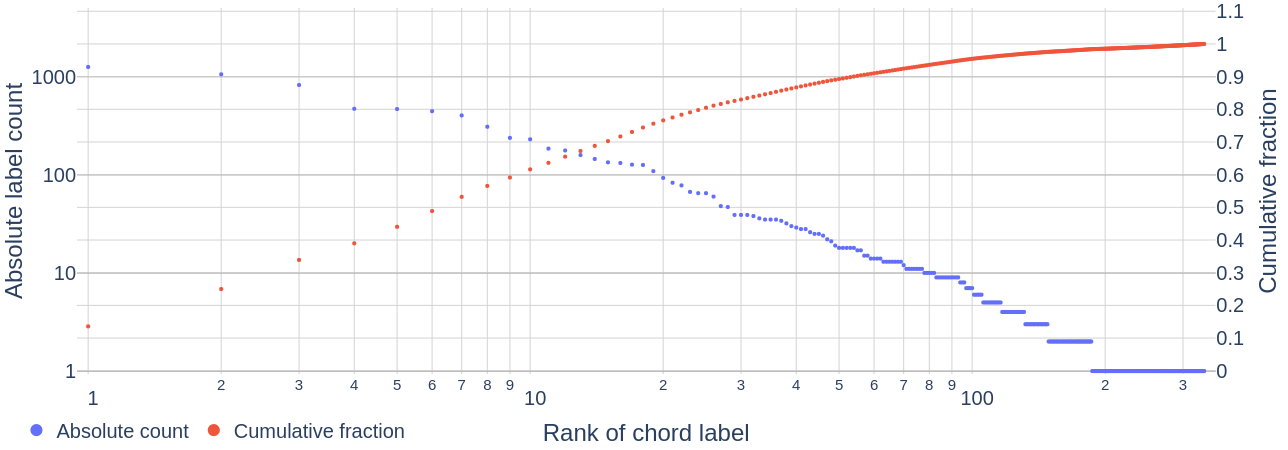

In [11]:
fig = plot_cum(df.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'type_distribution.png', height=400)
#fig.show()

## Unigrams in major segments

In [12]:
minor, major = df[df.localkey_is_minor], df[~df.localkey_is_minor]
print(f"{len(major)} tokens ({len(major.chord.unique())} types) in major and {len(minor)} ({len(minor.chord.unique())} types) in minor.")

4579 tokens (177 types) in major and 4672 (235 types) in minor.


In [13]:
major.chord.value_counts().iloc[:k]

I        987
V        656
I6       441
V7       257
V65      233
IV       176
ii65     159
V43      137
vi       129
V6       119
ii       105
V2        86
V(4)      86
IV6       85
ii7       58
V(64)     53
ii6       48
I64       38
V43/V     35
vi7       33
V65/V     30
ii43      29
vi6       28
iii6      26
IVM7      25
Name: chord, dtype: int64

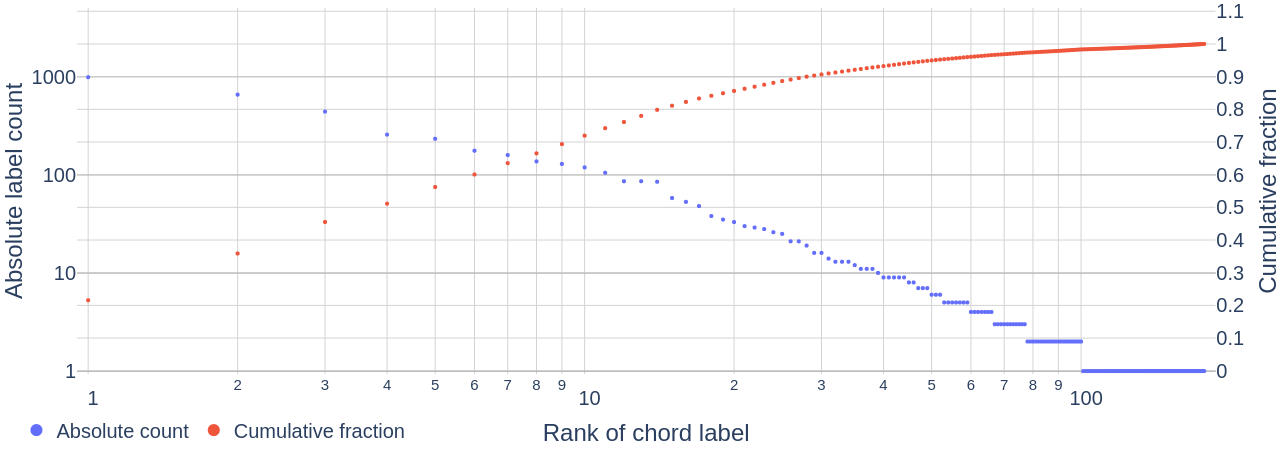

In [14]:
fig = plot_cum(major.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'unigrams_major.png', height=400)

## Unigrams in minor segments

In [15]:
print(f"{len(major)} tokens ({len(major.chord.unique())} types) in major and {len(minor)} ({len(minor.chord.unique())} types) in minor.")

4579 tokens (177 types) in major and 4672 (235 types) in minor.


In [16]:
minor.chord.value_counts().iloc[:k]

i         810
V         600
i6        399
V65       235
ii%65     232
V7        214
V43       172
ii%43     124
iv        123
V2         99
iv6        81
I          70
i64        67
V(4)       59
VI         58
v6         56
IV         54
VIM7       46
V65/iv     45
V6         40
V(64)      40
iv7        37
III        35
iio        35
ii%7       34
Name: chord, dtype: int64

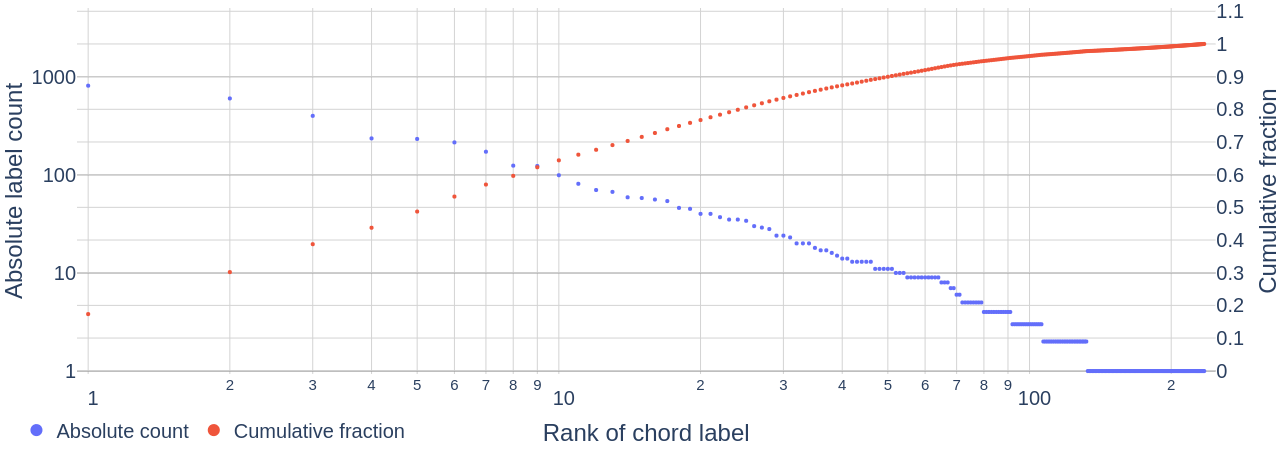

In [17]:
fig = plot_cum(minor.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'unigrams_major.png', height=400)

# Bigrams

In [18]:
chord_successions = [s.to_list() for _, s in df.groupby('key_regions').chord]

In [19]:
gs = grams(chord_successions)
c = Counter(gs)

In [20]:
dict(sorted(c.items(), key=lambda a: a[1], reverse=True)[:k])

{('V', 'I'): 268,
 ('V7', 'I'): 217,
 ('V', 'i'): 208,
 ('I', 'V'): 179,
 ('i', 'V'): 154,
 ('V', 'V7'): 153,
 ('V65', 'I'): 152,
 ('V7', 'i'): 135,
 ('ii%65', 'V'): 126,
 ('V', 'I6'): 125,
 ('V65', 'i'): 118,
 ('V(4)', 'V'): 107,
 ('V65', 'V7'): 107,
 ('I6', 'I'): 89,
 ('ii65', 'V'): 88,
 ('V43', 'i'): 88,
 ('V43', 'I'): 85,
 ('V', 'i6'): 82,
 ('V2', 'i6'): 82,
 ('i6', 'V43'): 79,
 ('I', 'I6'): 78,
 ('V2', 'I6'): 71,
 ('V', 'V2'): 69,
 ('i6', 'ii%65'): 67,
 ('I6', 'V43'): 65}

## Absolute Counts (read from index to column)

In [21]:
transition_matrix(chord_successions, k=k, dist_only=True)

,total,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,V(64),IV64,vi6,IV6,ii2,V43/V,V2,viio6,V7/IV,V65/IV,ii6,i,@none
I,758,179,78,50,49,48,42,37,32,28,22,14,13,13,10,10,10,8,8,8,7,6,6,6,5


,total,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,iv7,V(4),IV,iv,i2,V2,iv6,VI6,V65/iv,V/iv,VIM7,III6,v,iv7(9),iv64
i,639,154,56,55,38,27,25,20,17,15,14,14,14,10,9,9,8,7,7,7,7,7,7,6,6


,total,I,i,V7,I6,i6,V2,V65,V6,iii6,IV6,ii,V43,V6/iv,ii%43,i64,iv6,V65/iv,vi,I64,III+6,ii43,v6,v,IV6(2)
V,1193,268,208,153,125,82,69,50,22,15,14,13,12,9,9,8,8,7,7,7,6,5,5,5,4


,total,I,i,vi,V(64),V65,I64,VI,i6,i64,V/iv,I(7),V,I64(2),i(4),III+6,vi%7,I(4),IV6,i(9),IIIM7(#5),I6,V43,#viio,viio7/vi
V7,463,217,135,17,13,9,8,8,7,4,4,3,3,2,2,2,2,2,2,2,2,2,1,1,1


,total,I,V43,ii65,IV,V,vi,V(4),ii7,V65,V6,V(64),viio6,IM7,V7/IV,IV(9),IV6,IVM7,IVM2,V64,V65/IV,I64,IVM7(9),vi7,ii43
I6,438,89,65,64,40,31,17,14,14,9,9,9,8,7,6,5,4,4,3,3,3,3,3,2,2


,total,V43,ii%65,i,V65,V,ii%7,#viio65,iv,VI,iv7,i7,V(4),IV7(9),V(64),IV,ii%43,ii65,VIM7,V6,#viio6,IV2,i65,iv7(9),vi%7
i6,397,79,67,59,39,20,9,8,8,7,7,6,6,6,5,4,4,4,4,4,3,3,2,2,2


,total,i,I,i6,V65,I6,i64,V7,V,V2,V6,v7,iii,V65/iv,I64,I6(42),I(4),i6(119#7),I(9),vi6,ii7/IV,V(64),i(4),V/iv,i6(11#72)
V43,309,88,85,44,28,26,5,5,5,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,total,i6,I6,V43,i,ii6,V65/iv,III+7,I,V65,V65/ii,V65/IV,V6,V65(2),iii6,iv7(9),iii,vi64,III+,i6(b2),iv64,ii7/III,viio64,IV(97),v6(2)
V2,183,82,71,7,5,2,2,2,2,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0


,total,V,V(4),i6,i64,V(64),i,V2,ii%7,ii%43,V7,V64,V65,ii7,III+7,viio64,V65/V,V(#64),V43,V(64)/I,i6(112),v,V64(9)/iv,i6(11#72),ii6
ii%65,238,126,22,16,11,11,10,7,6,5,4,3,2,2,2,1,1,1,1,1,1,1,1,1,1


,total,V,V(4),ii43,V(64),ii7,I,V2,V7,I6,ii,I64,IV6,V64,V65/V,viio/V,i,iii6,ii(97),IV(9),i6(b2),V2(64),V65/IV,v6(2),VIM65
ii65,176,88,20,12,10,8,7,7,6,3,3,2,2,2,2,1,1,1,1,0,0,0,0,0,0


,total,I,i,V7,V,i6,I(4),i(4),V43,I(9),i(9),i(94),V2,V43/V,V/iv,I(94),I6,I64,ii%43,VIM7,V6,vi,iM7(9),i64,ii43
V65,465,152,118,107,17,10,9,7,6,6,5,4,3,3,2,2,2,2,1,1,1,1,1,1,1


,total,V,I,V43/V,i,vi,I6,vi7,v6,V65,V7,ii(4),V65/ii,i6,i64,V64,IV6,I64,iii%43,V2,iii65,VI6,III+6,iii6,vi6
V6,152,28,21,13,10,9,8,8,8,7,5,4,3,3,2,2,2,1,1,1,1,1,1,1,1


,total,ii,I6,V43,ii7,I,ii6,V,V65,V2,V/V,V65/V,IV6,V(4),ii65,IV2,IVM2,iio,IV7,vi,I64,viio,iio6,vi6,V7/VII
IV,216,43,27,24,14,13,12,11,9,7,6,6,6,3,3,3,2,2,2,2,2,1,1,1,1


,total,V,V7,V65,V6,vi,IV6,ii7,IV,iii(9),ii6,V6/V,V(64),#viio,V65/V,I(4),I6(112),V/V,V65(6)/ii,i6(11#72),V2,viio,iii7,I6(1196),V7/IV
ii,128,44,15,14,7,6,5,5,4,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1


,total,ii65,I6,IV,V65,IV6,V65/V,ii%65,vi6,I,V,I64,IVM7(9),ii65(2),ii,IVM7,V43,V2,iii6,vi2,ii%7,iii,V(4)/vi,V64/iv,V/VII
vi,121,30,21,19,9,9,3,3,3,3,3,3,2,2,2,2,1,1,1,1,1,1,1,0,0


,total,V,V7,V7(4),v,V6,V(64),I6,V65/V,iii6,ii%43,V65,V7(6)/ii,V65/IV,viio64,IV(97),v6(2),VIM65,IM7,V43/V,i(#7),viio6/VII,III,IV(9),iio6
V(4),145,107,21,5,4,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


,total,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),iv7,ii7,I64,IV6(2),V65,V(4),VII6,V64(9)/iv,ii6,viio6(2),vii%7(b8)/V,V6,V/VII,v(4),I6(7),iv6(2)
ii%43,127,44,42,12,9,5,3,3,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0


,total,iv6(2),iv6,VIM7,V2/iv,ii%43,V2/IV,i,IV6,V43/V,IIIM43,vi7,iii%43,III+6,IV43,IIIM65,#vi7,v,ii,III6,ii%43(4),iii7,#viio6/v,V6,v7
v6,63,8,8,7,5,4,4,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,total,ii%7,i64,V,ii%65,iio,i,V7/iv,i6,iv6,ii%43,III+6,V/III,V65/III,V43,ii,V(9),VII,IV,VII6,V6/III,iio6,V(64),i(4),VII/iv
iv,113,9,9,8,7,6,6,5,5,5,4,4,4,3,3,3,2,2,2,2,2,2,1,1,1


,total,ii%65,iv,ii65,i6,VIM2,ii7,iv6,i64,VI6,ii,ii%7,viio43,V2/III,iv7(9),VI2,IV7(9),V65/IV,v(4),IVM7(9),I6(7),iv6(2),i6(b2),V2(64),viio64
VI,48,23,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


,total,vi,vi7,ii6,iii,V7,IV6(94),viio6(2)/V,IV6(2),iiiM7,IIIM2,VIM65,V43/V,V65/ii,viio64,i(#7),IV(97),v6(2),IM7,iv2,viio6/VII,V2/III,III,IV(9),iio6
iii6,25,10,4,3,3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,total,V,V7,I6,V65,V43,V7(4),V(64),i6(11#72),I,V65/IV,ii%65,v7,i6(11),iio6,viio6,V65/V,viio6/VII,III,IM7,IV(9),VIM65,v6(2),IV(97),viio64
ii7,78,29,17,6,5,4,4,3,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


,total,ii%65,V(64),V,VII7,VII,#viio43,V65,V2,III+(9),ii65,iio,V/III,V7/III,ii,V(4),VII(9),V65/IV,V/VII,v(4),I6(7),iv6(2),i6(b2),V2(64),vi%7/V
iv7,38,8,6,6,2,2,2,2,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


,total,V65,IV,V7,I,I6,V6,V,IV7,ii,iv6,iii6,V(64),ii7,I(4),ii65,#viio,V65(9),ii6,III+6,viio,V7/IV,iio,V43,viio7
IV6,109,53,7,5,5,4,4,4,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1


,total,ii65,ii6,V65/V,V,V/IV,ii%43,V(4),iii6,V(64),V(11),I6,ii7(9),viio64,IV(97),i6(b2),V2(64),V65/IV,V65/ii,VIM65,v6(2),I6(7),IM7,viio6/VII,III
IVM7,28,7,6,3,3,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0


## Normalized Counts

In [22]:
transition_matrix(chord_successions, k=k, dist_only=True, normalize=True, decimals=2)

,total,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,V(64),IV64,vi6,IV6,ii2,V43/V,V2,viio6,V7/IV,V65/IV,ii6,i,@none
I,758,0.24,0.1,0.07,0.06,0.06,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,iv7,V(4),IV,iv,i2,V2,iv6,VI6,V65/iv,V/iv,VIM7,III6,v,iv7(9),iv64
i,639,0.24,0.09,0.09,0.06,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,I,i,V7,I6,i6,V2,V65,V6,iii6,IV6,ii,V43,V6/iv,ii%43,i64,iv6,V65/iv,vi,I64,III+6,ii43,v6,v,IV6(2)
V,1193,0.22,0.17,0.13,0.1,0.07,0.06,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0


,total,I,i,vi,V(64),V65,I64,VI,i6,i64,V/iv,I(7),V,I64(2),i(4),III+6,vi%7,I(4),IV6,i(9),IIIM7(#5),I6,V43,#viio,viio7/vi
V7,463,0.47,0.29,0.04,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,V43,ii65,IV,V,vi,V(4),ii7,V65,V6,V(64),viio6,IM7,V7/IV,IV(9),IV6,IVM7,IVM2,V64,V65/IV,I64,IVM7(9),vi7,ii43
I6,438,0.2,0.15,0.15,0.09,0.07,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0


,total,V43,ii%65,i,V65,V,ii%7,#viio65,iv,VI,iv7,i7,V(4),IV7(9),V(64),IV,ii%43,ii65,VIM7,V6,#viio6,IV2,i65,iv7(9),vi%7
i6,397,0.2,0.17,0.15,0.1,0.05,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,i,I,i6,V65,I6,i64,V7,V,V2,V6,v7,iii,V65/iv,I64,I6(42),I(4),i6(119#7),I(9),vi6,ii7/IV,V(64),i(4),V/iv,i6(11#72)
V43,309,0.28,0.28,0.14,0.09,0.08,0.02,0.02,0.02,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i6,I6,V43,i,ii6,V65/iv,III+7,I,V65,V65/ii,V65/IV,V6,V65(2),iii6,iv7(9),iii,vi64,III+,i6(b2),iv64,ii7/III,viio64,IV(97),v6(2)
V2,183,0.45,0.39,0.04,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),i6,i64,V(64),i,V2,ii%7,ii%43,V7,V64,V65,ii7,III+7,viio64,V65/V,V(#64),V43,V(64)/I,i6(112),v,V64(9)/iv,i6(11#72),ii6
ii%65,238,0.53,0.09,0.07,0.05,0.05,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),ii43,V(64),ii7,I,V2,V7,I6,ii,I64,IV6,V64,V65/V,viio/V,i,iii6,ii(97),IV(9),i6(b2),V2(64),V65/IV,v6(2),VIM65
ii65,176,0.5,0.11,0.07,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,i,V7,V,i6,I(4),i(4),V43,I(9),i(9),i(94),V2,V43/V,V/iv,I(94),I6,I64,ii%43,VIM7,V6,vi,iM7(9),i64,ii43
V65,465,0.33,0.25,0.23,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,I,V43/V,i,vi,I6,vi7,v6,V65,V7,ii(4),V65/ii,i6,i64,V64,IV6,I64,iii%43,V2,iii65,VI6,III+6,iii6,vi6
V6,152,0.18,0.14,0.09,0.07,0.06,0.05,0.05,0.05,0.05,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii,I6,V43,ii7,I,ii6,V,V65,V2,V/V,V65/V,IV6,V(4),ii65,IV2,IVM2,iio,IV7,vi,I64,viio,iio6,vi6,V7/VII
IV,216,0.2,0.12,0.11,0.06,0.06,0.06,0.05,0.04,0.03,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0


,total,V,V7,V65,V6,vi,IV6,ii7,IV,iii(9),ii6,V6/V,V(64),#viio,V65/V,I(4),I6(112),V/V,V65(6)/ii,i6(11#72),V2,viio,iii7,I6(1196),V7/IV
ii,128,0.34,0.12,0.11,0.05,0.05,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii65,I6,IV,V65,IV6,V65/V,ii%65,vi6,I,V,I64,IVM7(9),ii65(2),ii,IVM7,V43,V2,iii6,vi2,ii%7,iii,V(4)/vi,V64/iv,V/VII
vi,121,0.25,0.17,0.16,0.07,0.07,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0


,total,V,V7,V7(4),v,V6,V(64),I6,V65/V,iii6,ii%43,V65,V7(6)/ii,V65/IV,viio64,IV(97),v6(2),VIM65,IM7,V43/V,i(#7),viio6/VII,III,IV(9),iio6
V(4),145,0.74,0.14,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),iv7,ii7,I64,IV6(2),V65,V(4),VII6,V64(9)/iv,ii6,viio6(2),vii%7(b8)/V,V6,V/VII,v(4),I6(7),iv6(2)
ii%43,127,0.35,0.33,0.09,0.07,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,iv6(2),iv6,VIM7,V2/iv,ii%43,V2/IV,i,IV6,V43/V,IIIM43,vi7,iii%43,III+6,IV43,IIIM65,#vi7,v,ii,III6,ii%43(4),iii7,#viio6/v,V6,v7
v6,63,0.13,0.13,0.11,0.08,0.06,0.06,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


,total,ii%7,i64,V,ii%65,iio,i,V7/iv,i6,iv6,ii%43,III+6,V/III,V65/III,V43,ii,V(9),VII,IV,VII6,V6/III,iio6,V(64),i(4),VII/iv
iv,113,0.08,0.08,0.07,0.06,0.05,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


,total,ii%65,iv,ii65,i6,VIM2,ii7,iv6,i64,VI6,ii,ii%7,viio43,V2/III,iv7(9),VI2,IV7(9),V65/IV,v(4),IVM7(9),I6(7),iv6(2),i6(b2),V2(64),viio64
VI,48,0.48,0.1,0.08,0.06,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,vi,vi7,ii6,iii,V7,IV6(94),viio6(2)/V,IV6(2),iiiM7,IIIM2,VIM65,V43/V,V65/ii,viio64,i(#7),IV(97),v6(2),IM7,iv2,viio6/VII,V2/III,III,IV(9),iio6
iii6,25,0.4,0.16,0.12,0.12,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,I6,V65,V43,V7(4),V(64),i6(11#72),I,V65/IV,ii%65,v7,i6(11),iio6,viio6,V65/V,viio6/VII,III,IM7,IV(9),VIM65,v6(2),IV(97),viio64
ii7,78,0.37,0.22,0.08,0.06,0.05,0.05,0.04,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V(64),V,VII7,VII,#viio43,V65,V2,III+(9),ii65,iio,V/III,V7/III,ii,V(4),VII(9),V65/IV,V/VII,v(4),I6(7),iv6(2),i6(b2),V2(64),vi%7/V
iv7,38,0.21,0.16,0.16,0.05,0.05,0.05,0.05,0.05,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65,IV,V7,I,I6,V6,V,IV7,ii,iv6,iii6,V(64),ii7,I(4),ii65,#viio,V65(9),ii6,III+6,viio,V7/IV,iio,V43,viio7
IV6,109,0.49,0.06,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii65,ii6,V65/V,V,V/IV,ii%43,V(4),iii6,V(64),V(11),I6,ii7(9),viio64,IV(97),i6(b2),V2(64),V65/IV,V65/ii,VIM65,v6(2),I6(7),IM7,viio6/VII,III
IVM7,28,0.25,0.21,0.11,0.11,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Entropy

In [23]:
transition_matrix(chord_successions, k=k, IC=True, dist_only=True, smooth=1, decimals=2)

,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,entropy,V(64),IV64,vi6,IV6,ii2,V43/V,viio6,V2,V7/IV,V65/IV,i,ii6,@none
I,2.59,3.78,4.41,4.44,4.47,4.66,4.84,5.04,5.23,5.56,6.18,6.26,6.28,6.28,6.63,6.63,6.63,6.92,6.92,6.92,7.09,7.28,7.28,7.28,7.5


,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,V(4),IV,iv7,iv,entropy,i2,V2,iv6,V/iv,v,V65/iv,VIM7,VI6,III6,iv7(9),iv64
i,2.64,4.09,4.11,4.63,5.11,5.22,5.53,5.75,5.92,6.01,6.01,6.01,6.46,6.59,6.6,6.6,6.75,6.92,6.92,6.92,6.92,6.92,6.92,7.11,7.11


,I,i,V7,I6,i6,V2,V65,entropy,V6,iii6,IV6,ii,V43,V6/iv,ii%43,i64,iv6,I64,V65/iv,vi,III+6,v6,ii43,v,IV6(2)
V,2.5,2.86,3.3,3.59,4.2,4.44,4.9,5.43,6.05,6.57,6.66,6.76,6.87,7.25,7.25,7.4,7.4,7.57,7.57,7.57,7.76,7.99,7.99,7.99,8.25


,I,i,vi,entropy,V(64),V65,I64,VI,i6,i64,V/iv,I(7),V,i(4),IV6,IIIM7(#5),III+6,I6,vi%7,I64(2),i(9),I(4),V/IV,i6(11#72),iv7(9)
V7,1.86,2.54,5.46,5.82,5.82,6.31,6.46,6.46,6.63,7.31,7.31,7.63,7.63,8.04,8.04,8.04,8.04,8.04,8.04,8.04,8.04,8.04,8.63,8.63,8.63


,I,V43,ii65,IV,V,vi,V(4),ii7,V65,V(64),V6,viio6,IM7,entropy,V7/IV,IV(9),IVM7,IV6,V65/IV,V64,IVM7(9),IVM2,I64,vi64,ii43
I6,3.09,3.54,3.56,4.23,4.58,5.41,5.68,5.68,6.26,6.26,6.26,6.41,6.58,6.64,6.78,7.0,7.26,7.26,7.58,7.58,7.58,7.58,7.58,8.0,8.0


,V43,ii%65,i,V65,V,ii%7,iv,#viio65,VI,iv7,IV7(9),i7,V(4),entropy,V(64),V6,ii65,ii%43,IV,VIM7,IV2,#viio6,V64,iv7(9),IV(9)
i6,3.18,3.42,3.6,4.18,5.11,6.18,6.33,6.33,6.5,6.5,6.7,6.7,6.7,6.8,6.92,7.18,7.18,7.18,7.18,7.18,7.5,7.5,7.92,7.92,7.92


,i,I,i6,V65,I6,entropy,V7,i64,V,V2,V6,IV65,I(4),i6(9),ii7/IV,iii,v7,I(9),i6(119#7),V(64),I6(42),viio,ii7/iv,V65/iv,V/iv
V43,2.84,2.89,3.83,4.46,4.56,6.59,6.73,6.73,6.73,7.73,7.73,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32


,i6,I6,V43,i,entropy,ii6,III+7,I,V65,V65/iv,iv7(9),V65(2),V65/ii,V65/IV,iii,V6,iii6,vi64,viio6(2),iii2(9),iio6,IV(9),III,viio6/VII,IM7
V2,2.62,2.83,6.0,6.42,6.94,7.42,7.42,7.42,7.42,7.42,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0


,V,V(4),i6,i64,V(64),i,V2,ii%7,ii%43,V7,entropy,V64,V65,ii7,III+7,viio64,i6(11#72),v,V(#64),V43,V65/V,V2/V,i6(112),V(64)/I,ii6
ii%65,2.16,4.62,5.06,5.56,5.56,5.69,6.15,6.34,6.56,6.83,6.85,7.15,7.56,7.56,7.56,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15


,V,V(4),ii43,V(64),ii7,V2,I,V7,ii,I6,entropy,I64,V65/V,IV6,V64,i,iii6,viio/V,ii(97),iv6(2),III,i6(b2),V2(64),V65/IV,viio6/VII
ii65,2.5,4.59,5.28,5.52,5.81,5.98,5.98,6.17,6.98,6.98,7.21,7.4,7.4,7.4,7.4,7.98,7.98,7.98,7.98,8.98,8.98,8.98,8.98,8.98,8.98


,I,i,V7,V,entropy,i6,I(4),i(4),I(9),V43,i(9),i(94),V2,V43/V,I6,I64,V/iv,I(94),ii%43,I6(112),i64,iM7(9),i(2),VIM7,i6(11#72)
V65,2.38,2.74,2.88,5.46,5.91,6.17,6.31,6.63,6.83,6.83,7.05,7.31,7.63,7.63,8.05,8.05,8.05,8.05,8.63,8.63,8.63,8.63,8.63,8.63,8.63


,V,I,V43/V,i,vi,vi7,v6,I6,V65,V7,ii(4),V65/ii,i6,i64,IV6,V64,entropy,VI6,I64,III+6,V2,V43,iii65,iii%43,vi6
V6,4.05,4.45,5.1,5.45,5.59,5.74,5.74,5.74,5.91,6.32,6.59,6.91,6.91,7.32,7.32,7.32,7.73,7.91,7.91,7.91,7.91,7.91,7.91,7.91,7.91


,ii,I6,V43,ii7,I,ii6,V,V65,V2,IV6,V65/V,V/V,IV2,ii65,V(4),entropy,IV7,IVM2,I64,iio,vi,ii43,vi6,V6/V,V6
IV,3.63,4.28,4.45,5.18,5.28,5.39,5.51,5.77,6.09,6.28,6.28,6.28,7.09,7.09,7.09,7.45,7.51,7.51,7.51,7.51,7.51,8.09,8.09,8.09,8.09


,V,V7,V65,V6,vi,ii7,IV6,IV,iii(9),ii6,V6/V,entropy,I(4),V/V,V(64),viio7,iii7,V65/V,I6(1196),V7/IV,vi6,I6(112),iio,V2,i6(11#72)
ii,3.34,4.84,4.93,5.84,6.03,6.25,6.25,6.51,6.84,7.25,7.25,7.71,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84


,ii65,I6,IV,IV6,V65,I64,V,vi6,V65/V,I,ii%65,IVM7,IVM7(9),ii,ii65(2),entropy,ii%7,vi2,V43,iii6,V2,iii,V(4)/vi,IIIM2,v6(2)
vi,3.86,4.35,4.49,5.49,5.49,6.81,6.81,6.81,6.81,6.81,6.81,7.23,7.23,7.23,7.23,7.73,7.81,7.81,7.81,7.81,7.81,7.81,7.81,8.81,8.81


,V,V7,V7(4),v,entropy,V6,V65/V,iii6,V65,ii%43,I6,V(64),viio64,IV(97),v6(2),VIM65,IM7,III,IV(9),iio6,iii2(9),ii65/IV,#viio6/v,IV64(9),V6/v
V(4),2.13,4.43,6.3,6.57,7.05,7.3,7.89,7.89,7.89,7.89,7.89,7.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89


,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),entropy,IV6(2),VII6,V(4),V65,ii7,iv7,I64,vi(94),V/VII,v(4),I6(7),iv6(2),i6(b2),V6,V2(64),V65/ii
ii%43,3.34,3.41,5.13,5.51,6.25,6.83,6.83,7.25,7.49,7.83,7.83,7.83,7.83,7.83,7.83,7.83,8.83,8.83,8.83,8.83,8.83,8.83,8.83,8.83,8.83


,iv6,iv6(2),VIM7,V2/iv,V2/IV,ii%43,V43/V,i,IV6,IIIM43,v,#viio6/v,ii,iii7,#vi%7,iii%43,v7,III6,V7/iv,IIIM65,V6,vi7,V,IV43,IV6(9)
v6,5.44,5.44,5.61,6.03,6.29,6.29,7.03,7.03,7.03,7.03,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61


,ii%7,i64,V,ii%65,i,iio,i6,iv6,V7/iv,III+6,V/III,ii%43,V43,V65/III,ii,V(9),VII,IV,VII6,V6/III,iio6,ii6,V7,i(4),V/iv
iv,5.47,5.47,5.62,5.79,5.98,5.98,6.2,6.2,6.2,6.47,6.47,6.47,6.79,6.79,6.79,7.2,7.2,7.2,7.2,7.2,7.2,7.79,7.79,7.79,7.79


,ii%65,iv,ii65,i6,VIM2,iv6,VI2,iv7(9),ii7,viio43,ii,i64,IV7(9),V2/III,VI6,ii%7,entropy,V2/iv,viio64,IV(97),v6(2),VIM65,IM7,viio6/VII,III
VI,3.97,5.97,6.24,6.56,6.97,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,8.1,8.56,8.56,8.56,8.56,8.56,8.56,8.56,8.56


,vi,vi7,iii,ii6,IV6(2),V7,iiiM7,IV6(94),viio6(2)/V,entropy,iv2,V64/V,IV(97),v6(2),V43/iv,VIM65,IM7,viio64,viio6/VII,III,i(#7),IV(9),iio6,iii2(9),ii65/IV
iii6,5.01,6.15,6.47,6.47,7.47,7.47,7.47,7.47,7.47,8.25,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47


,V,V7,I6,V65,V43,V7(4),V(64),i6(11#72),I,viio6,v7,V65/IV,i6(11),iio6,ii%65,V65/V,entropy,IM7,VIM65,v6(2),IV(9),iii2(9),IV(97),ii65/IV,#viio6/v
ii7,3.76,4.5,5.86,6.08,6.35,6.35,6.67,7.08,7.67,7.67,7.67,7.67,7.67,7.67,7.67,7.67,7.91,8.67,8.67,8.67,8.67,8.67,8.67,8.67,8.67


,ii%65,V(64),V,VII7,V65,#viio43,V2,VII,VII(9),ii65,III+(9),ii,iio,V(4),V7/III,V/III,entropy,v7(9),V/VII,v(4),I6(7),iv6(2),i6(b2),V2(64),V65/IV
iv7,5.35,5.71,5.71,6.93,6.93,6.93,6.93,6.93,7.52,7.52,7.52,7.52,7.52,7.52,7.52,7.52,8.23,8.52,8.52,8.52,8.52,8.52,8.52,8.52,8.52


,V65,IV,V7,I,V,V6,I6,ii,IV7,iv6,ii7,I(4),V(64),iii6,entropy,V65(9),iio,V43,ii65,viio,ii6,III+6,#viio,viio7,vii%7
IV6,3.02,5.77,6.19,6.19,6.45,6.45,6.45,6.77,6.77,7.19,7.19,7.19,7.19,7.19,7.72,7.77,7.77,7.77,7.77,7.77,7.77,7.77,7.77,7.77,7.77


,ii65,ii6,V,V65/V,V/IV,V(64),viio64,ii7(9),V(11),iii6,I6,V(4),ii%43,entropy,VII(9),IV(97),v6(2),VIM65,IM7,viio6/VII,III,IV(9),iio6,iii2(9),ii65/IV
IVM7,5.48,5.67,6.48,6.48,7.48,7.48,7.48,7.48,7.48,7.48,7.48,7.48,7.48,8.26,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48


## Minor vs. Major

In [24]:
region_is_minor = df.groupby('key_regions').localkey_is_minor.unique().map(lambda l: l[0]).to_dict()
region_key = df.groupby('key_regions').localkey.unique().map(lambda l: l[0]).to_dict()

In [25]:
key_chords = {ix: s.to_list() for ix, s in df.reset_index().groupby(['fname', 'key_regions']).chord}
major, minor = [], []
for chords, is_minor in zip(key_chords.values(), region_is_minor.values()):
    (major, minor)[is_minor].append(chords)

In [26]:
transition_matrix(major, k=k, dist_only=True, normalize=True)

,total,V,I6,IV,V6,V65,vi,ii65,V(4),V7,V43,IVM7,IV64,V(64),vi6,ii2,IV6,V2,V43/V,viio6,V7/IV,ii6,V65/IV,@none,I64
I,736,0.24,0.1,0.07,0.07,0.06,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,I,I6,V7,V2,V65,iii6,V6,ii,IV6,I64,vi,ii43,IV6(2),v6,iii,I(9),IV,vi7,V65/IV,i,iii7,i6,V/V,vi6
V,629,0.38,0.2,0.13,0.05,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,V43,ii65,IV,V,vi,ii7,V(4),V65,V6,V(64),viio6,IM7,V7/IV,IV(9),IV6,IVM7,I64,V64,V65/IV,IVM7(9),IVM2,ii43,iv7
I6,434,0.2,0.15,0.14,0.09,0.07,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0


,total,I,vi,I64,V(64),V65,I(7),i,IV6,I6,I(4),V,I64(2),IVM7(9),IM7,vi6(2),IIIM7(9),VM7/IV,I6(2),viio7/vi,I(74),IV64(9),ii43,ii%7,IVM2(9)
V7,255,0.76,0.07,0.03,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,I6,V65,V,V7,i,V6,iii,viio,I(9),V2,IV65,I64,ii7/IV,I6(42),I(4),vi6,III,I7,V7/IV,IVM65,vi,IM7,ii
V43,137,0.61,0.19,0.06,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),ii43,V(64),ii7,I,V7,V2,I6,I64,V65/V,ii,IV6,viio/V,V64,ii(97),iii6,IM7,V/V,V7/IV,ii%7,III,vi,vi6
ii65,158,0.49,0.12,0.07,0.06,0.05,0.04,0.04,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii,I6,V43,I,ii7,ii6,V,V65,V2,IV6,V65/V,V/V,V(4),I64,ii65,IVM2,vi,vii%7,vi6,V(64),V64,V6,ii43,V7/V
IV,165,0.19,0.16,0.1,0.08,0.05,0.05,0.05,0.05,0.04,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,I,V43/V,vi,I6,vi7,ii(4),V65,V7,v6,V65/ii,IV6,V64,ii43,V65/V,V/V,iii65,V2,ii%43,vi6,iii,iii%43,iii6,IV
V6,113,0.18,0.18,0.12,0.08,0.07,0.07,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,I,V7,I(4),V,I(9),V43/V,I(94),I6,I64,vi,ii43,V43,I6(112),V7/IV,III,ii65/IV,IVM65,viio6,ii,IV(9),vi6,I7,iii%43,I(7)
V65,231,0.63,0.23,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii65,I6,IV,IV6,V65,I64,ii%65,I,vi6,V,ii,ii65(2),V65/V,IVM7(9),IVM7,iii6,vi2,V(4)/vi,V2,V43,iii,IM7,V7/IV,IVM65
vi,118,0.25,0.18,0.16,0.08,0.07,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0


,total,I6,V43,I,V65,i6,iii,iii6,V65/ii,V65/IV,V6,i,vi64,ii6,ii(64),viio6,ii65/IV,iii2(9),I(7),iii%43,I7,vi6,IV(9),ii,IV(4)
V2,85,0.81,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V65,V7,vi,V6,IV6,ii7,IV,iii(9),V6/V,I(4),viio,V65(6)/ii,iii7,I6(1196),V2,V7/IV,V65/V,ii6,V/vi,V/V,I6(112),ii(9),vi6
ii,100,0.34,0.12,0.1,0.06,0.06,0.05,0.04,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,V7,V7(4),V6,I6,V65,V(64),iii6,V/V,ii%7,IM7,IVM65,I(7),V7/IV,III,vi,ii,ii43,IV(9),vi6,I7,V64,iii%43,iii2(9)
V(4),86,0.77,0.13,0.03,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,vi,vi7,ii6,iii,IV6(94),IV6(2),V7,viio6(2)/V,iiiM7,ii6(2),V7/IV,I7,vi6,IV(9),ii,III,IM7,IVM65,I(7),I6,V/V,ii%7,ii43,V64
iii6,25,0.4,0.16,0.12,0.12,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,I6,V65,V7(4),V43,V(64),viio6,V65/V,I,V65/IV,I(7),iii%43,I7,ii43,vi6,V/V,IV(9),vi,III,ii%7,V7/IV,IVM65,IM7
ii7,58,0.36,0.21,0.1,0.07,0.07,0.07,0.05,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii65,ii6,V65/V,V,V(64),iii6,I6,V(4),V/IV,V(11),viio64,viio6/V,vi6,ii,vi,viio7,III,V7/IV,I(74),IVM65,IM7,IV64,IVM2(9),V/V
IVM7,25,0.28,0.24,0.12,0.08,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),ii7,V/V,V65/V,iii%43,I7,vi6,IV(9),ii,vi,III,iii2(9),V7/IV,IVM65,IM7,I6,ii%7,ii43,V64,I(7),ii65/IV,IV(97),IV64(9)
V43/V,35,0.83,0.09,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,V(4),V7(4),I,IV,V2,vi6,IV(9),ii,vi,III,IVM65,V7/IV,iii%43,IM7,I6,V/V,ii%7,ii43,V64,V6(4),I7,I(7)
V(64),53,0.57,0.19,0.13,0.06,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,vii%7,V6,V2,vi,I(7),iii%43,I7,vi6,IV(9),ii,V7/IV,III,IVM65,IM7,I6,V/V,ii%7,ii43,V64,iii2(9),ii65/IV,IV(97),IV64(9)
IV64,15,0.53,0.27,0.13,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,ii65,V(4),V7,I64,I6,V65,V64,I(7),iii%43,I7,vi6,IV(9),ii,III,vi,ii43,iii2(9),IVM65,IM7,V/V,ii%7,V7/IV,IV64(9)
ii43,29,0.38,0.34,0.07,0.07,0.07,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V6,vii%7,V65,V6(2),V/vi,V,V43/V,I6,ii,viio7,IV6,I,ii7,V2,vii7,i6,V/V,vii65(2),vi,III,V7/IV,IVM65,IM7,IV6(1172)
vi6,23,0.17,0.13,0.09,0.09,0.09,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65,viio,V65/V,V6,ii65/IV,I(7),iii%43,I7,vi6,IV(9),ii,III,vi,V7/IV,IVM65,IM7,I6,V/V,ii%7,ii43,iii2(9),IV64(9),V6(4),iii2(94)
ii2,10,0.6,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,vii65,iii2(9),I(7),iii%43,I7,vi6,IV(9),ii,vi,III,V7/IV,IVM65,IM7,I6,V/V,ii%7,ii43,V64,V6(4),ii65/IV,IV64(9),iii2(94),vii6(2)
I(4),19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,ii,I6,iii7,I6(2),I,ii7,V7,I6(7),V2,V65,IIIM7,V43,V(64),V6,vi,ii64,III,IV(9),IV64,viio7,vi6,IVM65,IM7
ii6,47,0.23,0.15,0.11,0.09,0.06,0.04,0.04,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65,I,IV,V,V7,I6,ii,V6,V(64),ii7,iii6,I(4),IV7,ii6,ii65,viio,V7/IV,viio7,V65(9),V43,vii%7,iii2(9),I(7),iii%43
IV6,85,0.46,0.06,0.06,0.05,0.05,0.05,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0


In [27]:
transition_matrix(minor, k=k, dist_only=True, normalize=True)

,total,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,IV,iv7,V(4),iv,V2,iv6,i2,v,VI6,III6,V65/iv,VIM7,iv64,V/iv,iv7(9)
i,631,0.24,0.09,0.09,0.06,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,i,i6,V7,V2,I,V65,V43,ii%43,V6/iv,i64,V6,iv6,V65/iv,IV6,III+6,v,V/iv,ii%65,@none,i(9),vi%7,III6,viio43,iv6(2)
V,564,0.37,0.14,0.12,0.07,0.05,0.05,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0


,total,V43,ii%65,i,V65,V,ii%7,iv,#viio65,VI,iv7,IV7(9),i7,V(4),V(64),ii%43,ii65,V6,VIM7,IV,IV2,#viio6,V2,V64,vi%7
i6,393,0.2,0.17,0.15,0.1,0.05,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,i,i6,V65,i64,I,V7,V,i(4),V6,i6(11#72),V65/iv,i6(2),V/iv,v7,ii7/iv,V2,i6(9),i6(119#7),V(64),V65/III,viio43,VII2,V65/IV,VI65
V43,172,0.49,0.26,0.12,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0


,total,i,I,VI,i6,V(64),V/iv,V65,i64,vi%7,i(9),IIIM7(#5),i(4),III+6,iv7(9),V/IV,V2,#viio7,V,viio/IV,III64,V43,i6(11#72),#viio,V64(13)
V7,208,0.64,0.11,0.04,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),i6,i64,V(64),i,V2,ii%7,ii%43,V7,V64,III+7,ii7,V65,V43,V64(9)/iv,V65/V,viio64,i6(112),i6(11#72),V(#64),ii6,v,V(64)/I
ii%65,232,0.52,0.09,0.07,0.05,0.05,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,V7,V,i6,i(4),I,i(9),V43,i(94),V2,V/iv,ii%43,i(2),I(9),i64,V6,i6(11#72),VIM7,iM7(9),IV(9),V65/V,III(9),viio43,viio64
V65,234,0.5,0.24,0.05,0.04,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i6,i,V43,V65/iv,III+7,I6,ii6,iv7(9),V65(2),V2(64),IV6/iv,V7(4)/iv,III(9),viio43,viio64,VII2,V65/IV,VI65,i7,iv6(2),v6(2),V65/V,V/VII,v(4)
V2,98,0.83,0.04,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,V2/iv,V(4),V,IVM65,V65,V6,VI6,iv,V65/IV,iv6,IV6,V7/iv,ii65,I6,V65/iv,vi%7/iv,bII,v(4),iM7(9),VI65,i7,#viio6/v,V2(64)
I,22,0.14,0.09,0.09,0.09,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),ii7,I64,V(4),VII6,V65,iv7,V/VII,viio43,viio64,VII2,V65/IV,VI65,i7,V2(64),iv6(2),V65/V
ii%43,124,0.35,0.32,0.1,0.07,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,iv6(2),iv6,VIM7,V2/iv,ii%43,IIIM43,i,V43/V,V7/iv,#vi%7,v7,IV6,III+6,IV43,ii%43(4),III6,V/iv,IIIM65,V,#viio6/v,V6,v,vi7,IV6(9)
v6,55,0.15,0.15,0.13,0.09,0.07,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


,total,i64,ii%7,V,ii%65,iio,i,V7/iv,i6,iv6,III+6,V/III,ii%43,ii,V43,V65/III,VII6,V(9),IV,VII,V6/III,iio6,V65/iv,III6,ii65
iv,111,0.08,0.07,0.07,0.06,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


,total,V,V7,v,V7(4),V65/V,ii%43,V6/III,V7/V,V7(4)/iv,III(9),viio43,IV/VII,viio64,VII2,V65/IV,VI65,i7,V2(64),iv6(2),V(#64),V/VII,v(4),i6(b2),V6
V(4),59,0.69,0.17,0.07,0.03,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,iv,ii65,i6,VIM2,ii,ii%7,viio43,ii7,VI6,VI2,iv6,IV7(9),iv7(9),i64,V2/III,V6/v,ii43,v6(2),V6(4),IV6/iv,V7(4)/iv,III(9),V65/v
VI,47,0.47,0.11,0.09,0.06,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,V,v6,i6,V65,i64,i6(11#72),V2/iv,V7,#vio6,III+6,V43,VI6,I,V65/IV,VII2,V6/v,i7,viio64,viio43,III(9),V7(4)/iv,IV6/iv,VI65
V6,39,0.26,0.21,0.13,0.08,0.08,0.05,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V,V(64),VII,V2,VII7,#viio43,ii65,V7/III,III+(9),ii,V/III,V(4),iio,VII(9),V/VII,i7,VI65,V65/IV,V2(64),iv6(2),V65/V,VII2,V6
iv7,36,0.22,0.17,0.17,0.06,0.06,0.06,0.06,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii,V43,ii7,IV2,ii6,V,iio,V/V,V65/V,ii65,iv7,iv,IVM7,V7/III,V2/VII,V65,V7/VII,IV7,VII,vi,viio6,V65/v,iio6,I6
IV,51,0.22,0.14,0.1,0.06,0.06,0.04,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0


,total,V,iv,V43/iv,ii%65,V7,iv7,V65/VII,III6,iio6,III6(2),VII,ii65,VI,V7/III,V65,iv2,V2/iv,i,i64,V(97),iv64,ii%7/iv,V/iv,IV
iv6,77,0.27,0.12,0.09,0.06,0.06,0.04,0.04,0.03,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii%43,V2,i6,ii%65,V43,vi%7,iv6,iv7,IV7,i,V7,VIM7,V65,#vi%7,VIM2,iio64,viio64,vi7,i6(6),viio43,VII2,V65/IV,VI65,i7
i64,67,0.3,0.24,0.07,0.07,0.06,0.03,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),V7,ii%65,V7(4),V2,iv7,v,v64,V2(64),V7(4)/iv,III(9),viio43,viio64,ii%43,V65/iv,VII2,V65/IV,VI65,i7,iv6(2),#viio,iv43,V65/V
V(64),39,0.67,0.15,0.05,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,V65,i6,#viio,V6,viio7,i6(11#72),ii7,iio,vi%7/V,ii6,ii2,V(64),viio7/V,i6(b2),viio43,viio64,VII2,V65/IV,VI65,i7,V2(64),iv6(2)
ii,28,0.36,0.18,0.07,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,ii%65,V43,V65/III,ii7,v7,VII6,ii%2,V(64),I64,v(4),III(9),viio43,viio64,VII2,V65/IV,VI65,i7,V2(64),iv6(2),V65/V,V/VII,i6(b2)
ii%7,34,0.35,0.21,0.18,0.09,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65/iv,iv,V7/IV,V7/iv,IV,V/iv,V65,v6(2),V6(4),IV6/iv,V7(4)/iv,III(9),viio43,viio64,VII2,V65/IV,VI65,i,V2(64),iv6(2),V65/V,V/VII,v(4),i6(b2)
V6/iv,13,0.31,0.23,0.15,0.15,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,i6,III+6,ii%65,VI6,VII,VIM7,VI,IIIM2,V/III,V64,III6,V65/III,iv,VI65,V65/IV,v6,V65,i64,V6/iv,II%65,v6(2),V6(4),IV6/iv
III,31,0.13,0.13,0.1,0.06,0.06,0.06,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0


,total,iv6,ii%43,V(#64),iv6(2),IV6/iv,V7(4)/iv,III(9),viio43,viio64,VII2,V65/IV,VI65,i7,V6(9),V2(64),V65/V,v6(2),V/VII,v(4),i6(b2),V6,V64(13),#viio,v64
iv6(2),13,0.92,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Chord progressions without suspensions

Here called *plain chords*, which consist only of numeral, inversion figures, and relative keys.

In [28]:
df['plain_chords'] = df.numeral + df.figbass.fillna('') + ('/' + df.relativeroot).fillna('')

In [29]:
df.plain_chords.iloc[:k]

fname           
00_allemande  0          V
              1         i6
              2          i
              3         V6
              4          V
              5       IV65
              6         V7
              7         i6
              8          i
              9        VI6
              10        ii
              11       VI6
              12    V7/III
              13       III
              14       V64
              15         i
              16      ii64
              17        iv
              18         V
              19      V/iv
              20    V65/iv
              21     V/VII
              22      VII6
              23        ii
              24       V65
Name: plain_chords, dtype: object

**Consecutive identical labels are merged**

In [30]:
def remove_subsequent_identical(col):
    return col[col != col.shift()].to_list()
key_regions_plain_chords = df.reset_index().groupby(['fname', 'key_regions']).plain_chords.apply(remove_subsequent_identical)
key_plain_chords = {ix: s for ix, s in key_regions_plain_chords.iteritems()}
major_plain, minor_plain = [], []
for chords, is_minor in zip(key_plain_chords.values(), region_is_minor.values()):
    (major_plain, minor_plain)[is_minor].append(chords)

In [31]:
plain_chords_per_segment = {k: len(v) for k, v in key_plain_chords.items()}

In [32]:
print(f"The local key segments have {sum(plain_chords_per_segment.values())} 'plain chords' without immediate repetitions, \
yielding {len(grams(list(key_plain_chords.values())))} bigrams.\n{sum(map(len, major_plain))} chords are in major, {sum(map(len, minor_plain))} in minor.")

The local key segments have 8766 'plain chords' without immediate repetitions, yielding 8172 bigrams.
4307 chords are in major, 4459 in minor.


In [33]:
{segment: chord_count  for segment, chord_count in list({(piece, region_key[key] + (' minor' if region_is_minor[key] else ' major')): v for (piece, key), v in plain_chords_per_segment.items()}.items())[:k]}

{('00_allemande', 'i minor'): 44,
 ('00_allemande', 'v minor'): 15,
 ('01_premier_prélude_JM', 'I major'): 4,
 ('01_premier_prélude_JM', 'V major'): 5,
 ('01_premier_prélude_JM', 'ii minor'): 2,
 ('02_second_prélude_JM', 'i minor'): 15,
 ('02_second_prélude_JM', 'III major'): 10,
 ('03_troisième_prélude_JM', 'i minor'): 26,
 ('03_troisième_prélude_JM', 'III major'): 14,
 ('03_troisième_prélude_JM', 'v minor'): 16,
 ('04_quatrième_prélude_JM', 'I major'): 13,
 ('04_quatrième_prélude_JM', 'IV major'): 6,
 ('04_quatrième_prélude_JM', 'V major'): 17,
 ('04_quatrième_prélude_JM', 'ii minor'): 4,
 ('05_cinquième_prélude', 'I major'): 14,
 ('05_cinquième_prélude', 'V major'): 20,
 ('05_cinquième_prélude', 'IV major'): 8,
 ('05_cinquième_prélude', 'ii minor'): 27,
 ('06_sixième_prélude', 'i minor'): 34,
 ('06_sixième_prélude', 'III major'): 24,
 ('06_sixième_prélude', 'VII major'): 8,
 ('06_sixième_prélude', 'v minor'): 13,
 ('06_sixième_prélude', 'iv minor'): 7,
 ('07_septième_prélude', 'I ma

In [34]:
from statistics import mean
print(f"Segments being in the same local key have a mean length of {round(mean(plain_chords_per_segment.values()), 2)} plain chords.")

Segments being in the same local key have a mean length of 14.76 plain chords.


### Most frequent 3-, 4-, and 5-grams in major

In [35]:
def sorted_gram_counts(l, n=2, k=k):
    return {t: count for t, count in sorted(Counter(grams(l, n=n)).items(), key=lambda a: a[1], reverse=True)[:k]}

sorted_gram_counts(major_plain, 3)

{('V', 'V7', 'I'): 98,
 ('I', 'V', 'I'): 94,
 ('I6', 'V43', 'I'): 55,
 ('ii65', 'V', 'I'): 55,
 ('V65', 'I', 'V'): 50,
 ('V65', 'V7', 'I'): 44,
 ('V', 'I6', 'I'): 40,
 ('V43', 'I', 'V'): 39,
 ('I6', 'I', 'V'): 36,
 ('ii65', 'V', 'V7'): 36,
 ('V', 'I', 'V'): 35,
 ('I', 'V', 'V7'): 33,
 ('I6', 'ii65', 'V'): 33,
 ('vi', 'ii65', 'V'): 32,
 ('IV6', 'V65', 'I'): 30,
 ('I', 'V', 'I6'): 29,
 ('I', 'V65', 'I'): 29,
 ('V', 'V2', 'I6'): 27,
 ('I', 'ii65', 'V'): 25,
 ('I6', 'V', 'I'): 24,
 ('V65', 'I', 'I6'): 22,
 ('V', 'I', 'I6'): 22,
 ('I', 'I6', 'V'): 20,
 ('V', 'V65', 'I'): 20,
 ('I', 'V7', 'I'): 19}

In [36]:
sorted_gram_counts(major_plain, 4)

{('ii65', 'V', 'V7', 'I'): 34,
 ('I', 'V', 'V7', 'I'): 27,
 ('I6', 'V43', 'I', 'V'): 21,
 ('vi', 'ii65', 'V', 'I'): 21,
 ('V65', 'I', 'V', 'I'): 19,
 ('V', 'I6', 'I', 'V'): 18,
 ('IV', 'I6', 'V43', 'I'): 16,
 ('V43', 'I', 'V', 'I'): 16,
 ('V', 'I6', 'V43', 'I'): 15,
 ('I6', 'ii65', 'V', 'I'): 15,
 ('I6', 'V', 'V7', 'I'): 14,
 ('I6', 'I', 'V', 'I'): 14,
 ('I', 'ii65', 'V', 'I'): 13,
 ('I6', 'ii65', 'V', 'V7'): 12,
 ('IV', 'V43', 'I', 'V'): 12,
 ('I', 'V65', 'I', 'V'): 12,
 ('I', 'V65', 'V7', 'I'): 12,
 ('I', 'V', 'I', 'V'): 12,
 ('V7', 'I', 'V7', 'I'): 12,
 ('V', 'I', 'V', 'I'): 11,
 ('vi', 'ii65', 'V', 'V7'): 10,
 ('V65', 'V7', 'I', 'V65'): 10,
 ('I', 'vi', 'ii65', 'V'): 10,
 ('V7', 'vi', 'ii65', 'V'): 9,
 ('V2', 'I6', 'ii65', 'V'): 9}

In [37]:
sorted_gram_counts(major_plain, 5)

{('I6', 'ii65', 'V', 'V7', 'I'): 11,
 ('I6', 'V43', 'I', 'V', 'I'): 10,
 ('vi', 'ii65', 'V', 'V7', 'I'): 9,
 ('V65', 'V7', 'I', 'V65', 'V7'): 9,
 ('V7', 'I', 'V65', 'V7', 'I'): 9,
 ('I', 'ii65', 'V', 'V7', 'I'): 9,
 ('V', 'I6', 'I', 'V', 'I'): 8,
 ('I', 'V65', 'V7', 'I', 'V65'): 8,
 ('I6', 'I', 'V', 'V7', 'I'): 8,
 ('I', 'V7', 'I', 'V7', 'I'): 8,
 ('V', 'I6', 'I', 'V', 'V7'): 7,
 ('V', 'I', 'V', 'V7', 'I'): 7,
 ('I6', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'IV', 'I6', 'V43', 'I'): 6,
 ('I', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'V7', 'vi', 'ii65', 'V'): 6,
 ('I6', 'IV', 'I6', 'V43', 'I'): 6,
 ('IV', 'I6', 'V43', 'I', 'V'): 6,
 ('V65', 'I', 'ii2', 'V65', 'I'): 5,
 ('I', 'I6', 'V', 'V7', 'I'): 5,
 ('V7', 'vi', 'ii65', 'V', 'V7'): 5,
 ('I6', 'IV', 'V43', 'I', 'V'): 5,
 ('V65', 'I', 'V', 'V7', 'I'): 5,
 ('V', 'I6', 'V43', 'I', 'V65'): 5,
 ('V7', 'I', 'V7', 'vi', 'ii65'): 5}

### Most frequent 3-, 4-, and 5-grams in minor

In [38]:
sorted_gram_counts(minor_plain, 3)

{('i', 'V', 'i'): 72,
 ('V', 'V7', 'i'): 58,
 ('ii65', 'V', 'i'): 54,
 ('V65', 'i', 'V'): 53,
 ('i6', 'V43', 'i'): 52,
 ('i6', 'ii65', 'V'): 51,
 ('V65', 'V7', 'i'): 45,
 ('ii65', 'V', 'V7'): 40,
 ('i', 'V65', 'i'): 39,
 ('ii43', 'ii65', 'V'): 37,
 ('V', 'i', 'V'): 35,
 ('V43', 'i', 'V'): 30,
 ('V', 'V2', 'i6'): 28,
 ('i', 'ii65', 'V'): 28,
 ('V2', 'i6', 'V43'): 25,
 ('i6', 'V65', 'i'): 23,
 ('V', 'i6', 'i'): 22,
 ('V43', 'i', 'V65'): 22,
 ('i', 'V', 'V7'): 22,
 ('VI', 'ii65', 'V'): 21,
 ('V', 'i6', 'V43'): 21,
 ('V', 'i', 'V65'): 20,
 ('V', 'V7', 'I'): 19,
 ('V7', 'i', 'V'): 19,
 ('ii65', 'V', 'i6'): 18}

In [39]:
sorted_gram_counts(minor_plain, 4)

{('ii65', 'V', 'V7', 'i'): 29,
 ('V43', 'i', 'V', 'i'): 20,
 ('V2', 'i6', 'V43', 'i'): 18,
 ('i6', 'ii65', 'V', 'i'): 17,
 ('i', 'V65', 'i', 'V'): 17,
 ('i6', 'ii65', 'V', 'V7'): 16,
 ('V65', 'i', 'V', 'i'): 16,
 ('V', 'i', 'V65', 'i'): 16,
 ('V', 'i', 'V', 'i'): 15,
 ('V', 'i6', 'V43', 'i'): 15,
 ('i', 'ii65', 'V', 'i'): 15,
 ('i6', 'V43', 'i', 'V'): 15,
 ('V43', 'i6', 'ii65', 'V'): 13,
 ('V43', 'i', 'V65', 'i'): 13,
 ('i6', 'V43', 'i', 'V65'): 13,
 ('i', 'V', 'V7', 'i'): 13,
 ('ii65', 'V', 'V7', 'I'): 10,
 ('i', 'V', 'i', 'V65'): 10,
 ('i', 'V', 'i', 'V'): 10,
 ('ii65', 'V', 'i6', 'V43'): 10,
 ('VI7', 'ii43', 'ii65', 'V'): 10,
 ('i', 'i6', 'ii65', 'V'): 10,
 ('V2', 'i6', 'ii65', 'V'): 9,
 ('i', 'V65', 'V7', 'i'): 9,
 ('V65', 'V7', 'i', 'V'): 9}

In [40]:
sorted_gram_counts(minor_plain, 5)

{('i6', 'ii65', 'V', 'V7', 'i'): 13,
 ('i6', 'V43', 'i', 'V', 'i'): 13,
 ('i', 'V', 'i', 'V65', 'i'): 10,
 ('V', 'i', 'V65', 'i', 'V'): 9,
 ('ii65', 'V', 'i6', 'V43', 'i'): 9,
 ('V65', 'V7', 'i', 'ii65', 'V'): 8,
 ('V', 'i6', 'V43', 'i', 'V'): 8,
 ('V43', 'i', 'V65', 'i', 'V'): 7,
 ('V65', 'i', 'V', 'i', 'V65'): 7,
 ('VI', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'V', 'i', 'V', 'i'): 6,
 ('V65/iv', 'iv', 'ii7', 'ii65', 'V'): 6,
 ('iv', 'ii7', 'ii65', 'V', 'i6'): 6,
 ('ii7', 'ii65', 'V', 'i6', 'V43'): 6,
 ('i6', '#vii65', 'i6', '#vii65', 'i6'): 6,
 ('ii65', 'i6', 'ii65', 'i6', 'ii65'): 6,
 ('i6', 'ii65', 'i6', 'ii65', 'i6'): 6,
 ('V65', 'i', 'i6', 'ii65', 'V'): 6,
 ('i', 'V65', 'i', 'V', 'i'): 6,
 ('i6', 'V43', 'i', 'V65', 'i'): 6,
 ('i6', 'V43', 'i6', 'ii65', 'V'): 5,
 ('ii43', 'ii65', 'V', 'V2', 'i6'): 5,
 ('i', 'V2', 'i6', 'V43', 'i'): 5,
 ('V', 'V2', 'i6', 'V43', 'i'): 5}

## Counting particular progressions

In [41]:
MEMORY = {}
l = list(key_plain_chords.values())
def look_for(n_gram):
    n = len(n_gram)
    if n in MEMORY:
        n_grams = MEMORY[n]
    else:
        n_grams = grams(l, n)
        MEMORY[n] = n_grams
    matches = n_grams.count(n_gram)
    total = len(n_grams)
    return f"{matches} ({round(100*matches/total, 3)} %)"

In [42]:
look_for(('i', 'v6'))

'28 (0.343 %)'

In [43]:
look_for(('i', 'v6', 'iv6'))

'10 (0.132 %)'

In [44]:
look_for(('i', 'v6', 'iv6', 'V'))

'8 (0.114 %)'

In [45]:
look_for(('i', 'V6', 'v6'))

'3 (0.04 %)'

In [46]:
look_for(('V', 'IV6', 'V65'))

'14 (0.185 %)'

## Chord progressions preceding phrase endings

In [47]:
def phraseending_progressions(df, n=3, k=k):
    selector = df.groupby(level=0).phraseend.apply(lambda col: col.notna().shift().fillna(True)).cumsum()
    print(f"{selector.max()} phrases overall.")
    phraseends = df.groupby(selector).apply(lambda df: df.chord.iloc[-n:].reset_index(drop=True)).unstack()
    return phraseends.groupby(phraseends.columns.to_list()).size().sort_values(ascending=False).iloc[:k]

In [48]:
phraseending_progressions(df)

737 phrases overall.


0      1      2
V      V7     I    71
V(4)   V      I    48
V      V7     i    42
I      V      I    29
V(64)  V      I    27
ii65   V      I    24
V(4)   V      i    23
i      V      i    21
ii%65  V      i    20
V65    i      V    16
V(64)  V      i    15
V(4)   V7     I    12
V65    I      V    12
V43    I      V    12
V      i      V     9
V7     i      V     9
ii%65  V      I     9
V43    i      V     8
i(4)   i      V     7
V(4)   V7     i     6
VIM7   ii%43  V     6
I6     V43    I     6
V(64)  V7     I     6
ii%43  ii%65  V     5
ii65   ii43   V     5
dtype: int64

In [49]:
phraseending_progressions(df, 4)

737 phrases overall.


0      1      2    3
ii65   V      V7   I    23
ii%65  V      V7   i    19
I      V      V7   I    15
ii65   V(4)   V    I    15
I      V(4)   V    I    14
i      V      V7   i    12
vi     ii65   V    I    12
ii%65  V(4)   V    i    11
V43    i      V    i    10
       I      V    I    10
I6     V      V7   I     9
i      V(4)   V    i     8
I6     V(4)   V    I     7
i      ii%65  V    i     7
I      ii65   V    I     7
ii%65  V(64)  V    i     7
       V      V7   I     6
IV     V43    I    V     6
I6     V(64)  V    I     6
I      V(64)  V    I     6
i      V      V7   I     5
V65    i(4)   i    V     5
I6     V43    I    V     5
IV     I6     V43  I     5
V(64)  V      V7   I     5
dtype: int64